In [36]:
#Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [20]:
# Load training data
data = pd.read_csv("E:/MASTERS/Term 4- Winter 2/Social Media/Group assignment/train.csv")


In [21]:
data.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


In [22]:
# Create transformations (difference and ratio)
for feature in ['follower_count', 'following_count', 'listed_count', 'mentions_received', 'retweets_received', 'mentions_sent', 'retweets_sent', 'posts', 'network_feature_1', 'network_feature_2', 'network_feature_3']:
    data[f'{feature}_diff'] = data[f'A_{feature}'] - data[f'B_{feature}']
    #data[f'{feature}_ratio'] = data[f'A_{feature}'] / (data[f'B_{feature}'] + 1)  # +1 to avoid division by zero


In [23]:
data.columns

Index(['Choice', 'A_follower_count', 'A_following_count', 'A_listed_count',
       'A_mentions_received', 'A_retweets_received', 'A_mentions_sent',
       'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3',
       'follower_count_diff', 'following_count_diff', 'listed_count_diff',
       'mentions_received_diff', 'retweets_received_diff',
       'mentions_sent_diff', 'retweets_sent_diff', 'posts_diff',
       'network_feature_1_diff', 'network_feature_2_diff',
       'network_feature_3_diff'],
      dtype='object')

In [24]:
# Selecting transformed features for the model
features = [col for col in data.columns if 'diff' in col or 'ratio' in col]


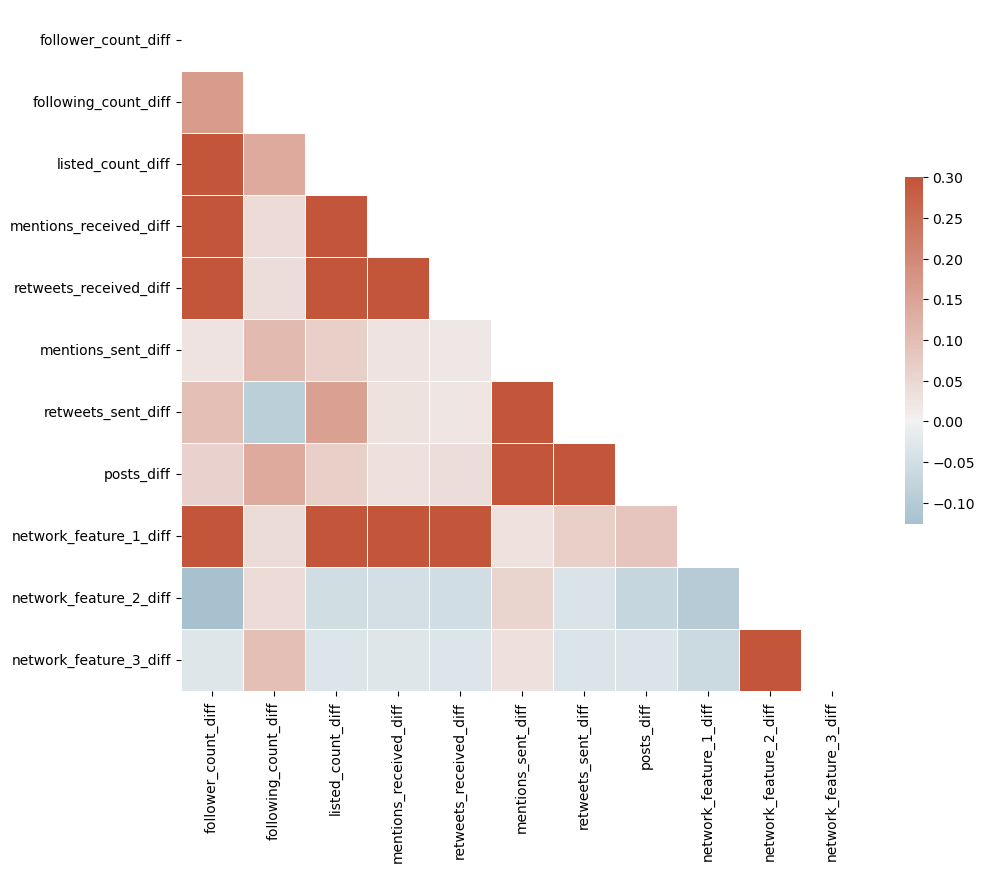

In [35]:
# Calculate the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [25]:

X = data[features]
y = data['Choice']


In [41]:
def calculate_vif(X):
    """Calculates VIF for each feature in a given DataFrame."""
    # Adding a constant to include the intercept
    X_const = add_constant(X)
    vif_df = pd.DataFrame({
        "Feature": X_const.columns,
        "VIF": [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    })
    return vif_df
calculate_vif(X)

,Feature,VIF
0,const,1.001156
1,follower_count_diff,4.666030
2,following_count_diff,1.119128
3,listed_count_diff,5.989018
4,mentions_received_diff,44.226529
5,retweets_received_diff,53.993595
6,mentions_sent_diff,2.047032
7,retweets_sent_diff,1.670296
8,posts_diff,1.622154
9,network_feature_1_diff,11.267619


In [44]:
def remove_high_vif_features(X, threshold=8.0):
    """Removes features with VIF above a specified threshold."""
    condition = True  # Initialize condition for while loop
    while condition:
        X_const = add_constant(X)  # Add constant for VIF calculation
        vifs = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
        vif_df = pd.DataFrame(vifs, index=X_const.columns, columns=["VIF"])
        # Filter to find features with VIF above threshold, excluding 'const'
        above_threshold = vif_df[vif_df["VIF"] > threshold].drop('const', errors='ignore')
        if not above_threshold.empty:
            # Remove the feature with the highest VIF
            feature_to_remove = above_threshold["VIF"].idxmax()
            X = X.drop(columns=[feature_to_remove])
            print(f"Removed: {feature_to_remove}")
        else:
            condition = False  # No more features above threshold; exit loop
    return X

# Assuming X is your DataFrame with the features
X_reduced = remove_high_vif_features(X)


Removed: retweets_received_diff
Removed: mentions_received_diff


In [45]:
calculate_vif(X_reduced)

,Feature,VIF
0,const,1.000921
1,follower_count_diff,2.675273
2,following_count_diff,1.114927
3,listed_count_diff,3.262423
4,mentions_sent_diff,2.027395
5,retweets_sent_diff,1.603642
6,posts_diff,1.595566
7,network_feature_1_diff,1.798282
8,network_feature_2_diff,1.469506
9,network_feature_3_diff,1.423972


In [47]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)


In [48]:
# Standardize the features - Fit on training data and transform both training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to retain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [49]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [50]:

# Predictions and confusion matrix
predictions = clf.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

[[408 122]
 [140 430]]


In [51]:
# Extracting feature importance correctly
feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train_scaled.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                        importance
listed_count_diff         0.223857
follower_count_diff       0.160016
network_feature_1_diff    0.153463
mentions_sent_diff        0.083592
posts_diff                0.080959
network_feature_2_diff    0.077706
following_count_diff      0.077202
network_feature_3_diff    0.073551
retweets_sent_diff        0.069655


In [52]:
# Performance Metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Detailed classification report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.74      0.77      0.76       530
           1       0.78      0.75      0.77       570

    accuracy                           0.76      1100
   macro avg       0.76      0.76      0.76      1100
weighted avg       0.76      0.76      0.76      1100



In [32]:
# Define the model and parameters for grid search
clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best model after grid search
best_clf = grid_search.best_estimator_

# Predictions
predictions = best_clf.predict(X_test_scaled)

In [33]:
# Detailed classification report
print(classification_report(y_test, predictions))

# Best model's parameters
print("Best model's parameters:", grid_search.best_params_)

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       530
           1       0.78      0.77      0.77       570

    accuracy                           0.76      1100
   macro avg       0.76      0.76      0.76      1100
weighted avg       0.76      0.76      0.76      1100

Best model's parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
